VAE with disentanglement

In [46]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
import torch.utils.data.dataloader as dataloader
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt

from PIL import Image

batchsize = 15
epochs=1000
loginterval=10
cuda = torch.cuda.is_available()

SEED = 1
torch.manual_seed(SEED)

device = torch.device("cuda" if cuda else "cpu")


In [47]:
transformations = transforms.Compose([transforms.Grayscale(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20, resample=Image.BILINEAR),
    transforms.ToTensor()
])
image_data = datasets.ImageFolder('Face2',transformations)

### Split the data_set into a train and test dataset where 80% of the data as are used for training.
train_size = int(0.8 * len(image_data))
test_size = len(image_data) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(image_data, [train_size, test_size])

In [48]:
# Loading datas 4 by 4 
dataloader_args = dict(shuffle=True, batch_size=4,num_workers=4, pin_memory=True)
train_loader = dataloader.DataLoader(train_dataset, **dataloader_args)
# Loading the test datas in one step 
dataloader_args = dict(shuffle=True, batch_size=len(test_dataset),num_workers=4, pin_memory=True)
test_loader = dataloader.DataLoader(test_dataset, **dataloader_args)

In [49]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # create using nn.Sequential()
        # decoder :FC (20 -> 400), RELU activation; FC (400, 784)

        self.fc1=nn.Linear(64*64,400)
        self.fcmu=nn.Linear(400,20)
        self.fcvar=nn.Linear(400,20)
        
        self.decoder = nn.Sequential(
                nn.Linear(20, 400),
                nn.ReLU(),
                nn.Linear(400, 64*64),
                )
        # and without using nn.Sequential, an encoder
        #FC (784 -> 400), RELU activation
        # then in parallel a FC (400, 20) for each mu / logvar

    def encode(self, x):
        relu_x = F.relu(self.fc1(x))
        mu = self.fcmu(relu_x)
        logvar = self.fcvar(relu_x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        # sample
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        
        return eps.mul(std).add_(mu)

    def decode(self, z):
        return torch.sigmoid(self.decoder(z))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 64*64))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

losses = []
gradients = []

In [50]:
def loss_function(recon_batch, x, mu, logvar, beta):
    # compute binary cross entropy summed across the batch
    #bce = nn.BCELoss(size_average=False)
    bce = F.binary_cross_entropy(recon_batch, x.view(-1, 64*64), reduction='sum')
    #   Kullback-Leibler divergence losses summed over all elements and batch
    #kld = nn.KLDivLoss(size_average=False)
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    # the beta factor allows disentanglement for values >>1
    return bce+kld*beta

In [51]:
def train(epoch, beta):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar, beta)
        losses.append(loss.cpu().item())
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % loginterval == 0:
            print('\r Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.1f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)), end='')

    print(' Average loss: {:.1f}'.format(
         train_loss / len(train_loader.dataset)), end='')

In [52]:
def test(epoch, beta):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar,beta)

            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(-1, 1, 64, 64)[:n]])
                save_image(comparison.cpu(),
                         'results/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print(' Test loss: {:.1f}'.format(test_loss))

In [ ]:
beta = 20
for epoch in range(1, epochs + 1):
    train(epoch, beta)
    test(epoch, beta)
    with torch.no_grad():
         sample = torch.randn(64, 20).to(device)
         sample = model.decode(sample).cpu()
         save_image(sample.view(-1, 1, 64, 64), 'results/sample_' + str(epoch) + '.png')    

 Train Epoch: 1 [160/193 (82%)]	Loss: 2888.9 Average loss: 2679.5 Test loss: 2644.2
 Train Epoch: 2 [160/193 (82%)]	Loss: 2652.5 Average loss: 2600.8 Test loss: 2626.2
 Train Epoch: 3 [160/193 (82%)]	Loss: 2687.1 Average loss: 2592.3 Test loss: 2583.3
 Train Epoch: 4 [160/193 (82%)]	Loss: 2480.8 Average loss: 2557.0 Test loss: 2544.8
 Train Epoch: 5 [160/193 (82%)]	Loss: 2823.0 Average loss: 2500.2 Test loss: 2519.3
 Train Epoch: 6 [160/193 (82%)]	Loss: 2462.7 Average loss: 2528.0 Test loss: 2532.8
 Train Epoch: 7 [160/193 (82%)]	Loss: 2591.5 Average loss: 2509.8 Test loss: 2506.2
 Train Epoch: 8 [160/193 (82%)]	Loss: 2538.6 Average loss: 2493.8 Test loss: 2481.7
 Train Epoch: 9 [160/193 (82%)]	Loss: 2794.6 Average loss: 2500.3 Test loss: 2515.6
 Train Epoch: 10 [160/193 (82%)]	Loss: 2549.7 Average loss: 2515.3 Test loss: 2441.2
 Train Epoch: 11 [160/193 (82%)]	Loss: 2788.9 Average loss: 2470.2 Test loss: 2497.8
 Train Epoch: 12 [160/193 (82%)]	Loss: 2335.1 Average loss: 2480.8 Test lo

In [41]:
# sample = torch.empty(64, 20)

# create a batch of 8x8 inputs sampled from normal distribution
# observe the image with different values of beta (0, 1, 10, 100)

save_image(sample.view(-1, 1, 64, 64), 'results/sample_continuous.png')

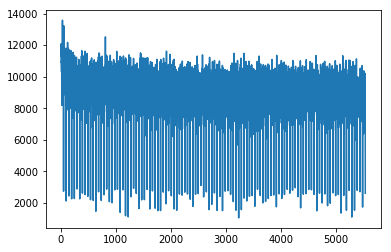

In [42]:
# plot losses
plt.plot(losses)

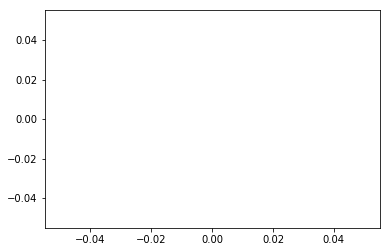

In [9]:
#plot the gradient mean value for each FC layer across training
plt.plot(gradients)